

## Step 1: Dataframe transformation & Data cleaning:
#### Steps:
1. Import libraries
2. Import data
3. DataFrame transformation
4. Clean Text data
5. Save cleaned Data

## Step 2: Ananlysis on cleaned data:
#### Steps:
1. Import cleaned data
2. Corpus creation
3. Bag of Words example
4. TF-IDF example

## Step 3: Latent Semantic Analysis:
#### Steps: Process to be repeated for all reviews, from 1 - 5 Star reviews
1. Create Review groups Dataframes
2. Model creatioin and avaluation
3. Use best model to find word distributions of the reviews


## Step 4: Latent Dirichlet Allocation:
#### Steps: Process to be repeated for all reviews, from 1 - 5 Star reviews
1. Make Bigrams and Trigrams of all the words in the 1 star reviews
2. Create dictionary containing each word and the number of times that word appears
3. Create a Wordcloud to visualize the words contained within the 1 star reviews
4. Run LDA model and find best number of clusters, visualizing Coherence scores
5. Create the best LDA model using cluster with highest coherence score and find the Topic-Word distribution for each topic
6. Document-Topic assignment and visualization Bar graph
7. Results interpretation

___

***

# Step 1

### 1.1.  Import libraries

In [1]:
# Basic data manipulation.
import string
import pandas as pd
import numpy as np

# String manipulation of the text data.
import re
import contractions

# Spelling correction
from textblob import TextBlob
from spellchecker import SpellChecker

# String processing.
import nltk
from nltk.tokenize import word_tokenize, WordPunctTokenizer
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

# Word Stemming
from nltk.stem import PorterStemmer, SnowballStemmer

# Word Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

# Word embedding : Bag of Words and TF-IDF
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Topic identification : LSA & LDA
from gensim import corpora, models
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Plotting
import matplotlib.pyplot as plt

# WordCloud Visualization
from wordcloud import WordCloud

### 1.2.  Import Data

In [107]:
# Import data
review_data = pd.read_csv('raw_yelp_review_data.csv')
review_data

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating
...,...,...,...
7611,The Steeping Room,2/19/2015 I actually step into this restauran...,4.0 star rating
7612,The Steeping Room,"1/21/2016 Ok, The Steeping Room IS awesome. H...",5.0 star rating
7613,The Steeping Room,"4/30/2015 Loved coming here for tea, and the ...",4.0 star rating
7614,The Steeping Room,8/2/2015 The food is just average. The booths...,3.0 star rating


### 1.3.  DataFrame Transformation
First need to transform dataframe by removing the column 'coffee_shop_name' and also obtain a single value integer for the 'star_rating'.

Then, I will simplify the dataset by extracting and using only the first 200 reviews for each rating. In total there will be 1000 reviews evenly spread accross all rating values, ranging from 1-5.

In [108]:
review_data['star_rating'] = review_data['star_rating'].apply(lambda x: x[:2])
review_data.drop(columns='coffee_shop_name', inplace=True)
review_data['star_rating'] = review_data['star_rating'].astype(int)

# Rename Columns
review_data.columns = ['Review','Rating']

review_data.drop_duplicates(subset='Review', inplace=True)
review_data.reset_index(drop=True, inplace=True)

In [109]:
s1,s2,s3,s4,s5 = 0,0,0,0,0

for i in range(0,review_data.shape[0]):
    if review_data['Rating'][i] == 1:
        s1 += 1
        if s1 > 200:
            review_data.drop(i, inplace=True)
     
    elif review_data['Rating'][i] == 2:
        s2 += 1
        if s2 > 200:
            review_data.drop(i, inplace=True)
        
    elif review_data['Rating'][i] == 3:
        s3 += 1
        if s3 > 200:
            review_data.drop(i, inplace=True)
    
    elif review_data['Rating'][i] == 4:
        s4 += 1
        if s4 > 200:
            review_data.drop(i, inplace=True)
    
    elif review_data['Rating'][i] == 5:
        s5 += 1
        if s5 > 200:
            review_data.drop(i, inplace=True)

In [110]:
review_data.reset_index(drop=True, inplace=True)

# View dataframe
review_data

,Review,Rating
0,11/25/2016 1 check-in Love love loved the atm...,5
1,"12/2/2016 Listed in Date Night: Austin, Ambia...",4
2,11/30/2016 1 check-in Listed in Brunch Spots ...,4
3,11/25/2016 Very cool decor! Good drinks Nice ...,2
4,12/3/2016 1 check-in They are located within ...,4
...,...,...
995,10/25/2016 Updated review Listed in Coffee Sh...,1
996,10/19/2016 Strange Brew has been one of my go...,1
997,6/1/2016 Think I'm getting too old for places...,1
998,8/18/2016 I gave you a one because your toile...,1


### 1.4.  Clean Data
The cleaning of data is necessary for us in order to be able to do effective text analytics.

Cleaning of the data includes:
- Removing duplicates
- Removing numbers and stopwords
- Remove punctuation
- Expanding contractions
- Stemming and Lemmatization
- Correcting spelling errors

In [111]:
# Create a function that we can call to process whichever input dataframe that we might have
def text_cleaning(input_df):
    # First step is to drop the duplicate reviews, since the same person is able to write the same review more then once in order to affect the ratings.
    input_df.drop_duplicates(keep='last' , subset=['Review'], inplace=True)
    # Re-index dataframe
    input_df.reset_index(drop=True, inplace=True)

    # Make text lowercase
    input_df['Review'] = input_df['Review'].str.lower()

    # Remove '\n' , which indicates new lines
    input_df['Review'] = input_df['Review'].replace('\\\\n',' ', regex=True)

    # Remove punctuation and replace with a 'space' using regex
    input_df['Review'] = input_df['Review'].apply(lambda x: re.sub(r'[^\w\s]',' ', x))

    # Remove numbers.
    input_df['Review'] = input_df['Review'].replace('[0-9]',' ', regex=True)

    # Expand contractions, "you're" turned into "you are"
    input_df['Review'] = input_df['Review'].apply(lambda x: contractions.fix(x))

    """
    # Stemming
    If you want to stemm the words to remove the affixes and suffixes, only remove out the commented string on top and down below.

    # Using the PorterStemmer
    pv = PorterStemmer()
    input_df['Review'] = input_df['Review'].apply(lambda x: (str([pv.stem(y) for y in x.split()])) )
    
    # Using the snowballStemmer, more accurate
    sbs = SnowballStemmer('english')
    input_df['Review'] = input_df['Review'].apply(lambda x: (str([sbs.stem(y) for y in x.split()])) )
    """

    # Correct spelling mistakes, this might take a while.
    # First create a list of all the words spelled wrong.
    words = " ".join([word for word in input_df['Review']]).split()
    # Initialize spell checker
    spell = SpellChecker()
    misspelled = spell.unknown(words)
    
    # Then we go through each word for each review in our column 'Review', and if the word is in our list of misspelled words, 
    # then only that word should be corrected.
    for i in range (input_df.shape[0]):
        for w in input_df['Review'][i].split():
            if w in misspelled:
                TextBlob(w).correct()
    """
    You might be wondering why we aren't just calling 'TextBlob.correct()' on the entire column and correct it all at once.
    The problem is that TextBlob corrects words that might already be correct,
    based on the assumption of what one might have ment and in accordance to how often certain words are used in the 
    English language. This leads to some errors. For example, at review 10, the word gluten is mentioned, 
    which is a normal and correctly spelled word. Although when we run it through TextBlob.correct() function, 
    it returns the word 'lumen' which has nothing to do with gluten.
    """

    # Removing stopwords with Gensim library
    input_df['Review'] = input_df['Review'].apply(lambda x: remove_stopwords(x))
    
    # Remove all non-English words or words that was unable to be corrected by the spell checker.
    # We use WordPunctTokenizer to remove all non English words and Tokenize the string, 
    # which is needed for removing stopwords and lemmitization, all at once.
    wpt = WordPunctTokenizer()
    input_df['Review'] = input_df['Review'].apply(lambda sen: [w for w in wpt.tokenize(sen)])
    
    # Remove additional stopwords.
    ad_stop_words = ['pacha','place','checking','would','came','give','even','also','actually','good','well','like',
                     'definitely','going','want','austin','told','took','truly','boyfriend','went', 'back', 'haus', 'wasn'
                    ,'come', 'thing', 'great', 'fcks', 'shit', 'bitch', 'idiotic', 'coffee']
    input_df['Review'] = input_df['Review'].apply(lambda words: [word for word in words if word not in ad_stop_words])
    


    # Lemmatize the words that we have for each review.
    lemmatizer = WordNetLemmatizer()
    input_df['Review'] = input_df['Review'].apply(lambda x: [lemmatizer.lemmatize(t) for t in x])

    # Remove words shorten than 3 characters, since they hold no descriptive value in this case.
    input_df['Review'] = input_df['Review'].apply(lambda words: [word for word in words if len(word)>3])

    # Our review column is currently a list. We need to make it into a normal string without any punctiation again.
    input_df['Review'] = input_df['Review'].astype(str)
    input_df['Review'] = input_df['Review'].str.translate(str.maketrans(" ", " ", string.punctuation))

In [112]:
# DataFrame before cleaning
review_data

,Review,Rating
0,11/25/2016 1 check-in Love love loved the atm...,5
1,"12/2/2016 Listed in Date Night: Austin, Ambia...",4
2,11/30/2016 1 check-in Listed in Brunch Spots ...,4
3,11/25/2016 Very cool decor! Good drinks Nice ...,2
4,12/3/2016 1 check-in They are located within ...,4
...,...,...
995,10/25/2016 Updated review Listed in Coffee Sh...,1
996,10/19/2016 Strange Brew has been one of my go...,1
997,6/1/2016 Think I'm getting too old for places...,1
998,8/18/2016 I gave you a one because your toile...,1


In [113]:
# Cleaning
# Apply the created function above on our imported data
text_cleaning(review_data)

In [114]:
# View what our dataframe looks like now, after cleaning
review_data

,Review,Rating
0,check love love loved atmosphere corner shop s...,5
1,listed date night ambiance beautiful love ambi...,4
2,check listed brunch spot loved eclectic homey ...,4
3,cool decor drink nice seating overpriced extra...,2
4,check located northcross mall shopping center ...,4
...,...,...
995,updated review listed shop think cool worked,1
996,strange brew spot loyal customer year twice we...,1
997,think getting place music nice incredibly grun...,1
998,gave toilet urinal stained drop urine cleaner ...,1


### 1.5.  Save cleaned data

In [115]:
review_data.to_csv('Cleaned Cafe data.csv', index=False)

***

___

# Step 2

### 2.1.  Import cleaned data
Don't have to rerun the cleaning each time

In [2]:
reviews = pd.read_csv('Cleaned Cafe data.csv')

In [3]:
# Create a new column consisting of a list with all of the words found in the review
reviews['Review clean'] = reviews['Review'].apply(lambda x: x.split())
reviews.head()

,Review,Rating,Review clean
0,check love love loved atmosphere corner shop s...,5,"[check, love, love, loved, atmosphere, corner,..."
1,listed date night ambiance beautiful love ambi...,4,"[listed, date, night, ambiance, beautiful, lov..."
2,check listed brunch spot loved eclectic homey ...,4,"[check, listed, brunch, spot, loved, eclectic,..."
3,cool decor drink nice seating overpriced extra...,2,"[cool, decor, drink, nice, seating, overpriced..."
4,check located northcross mall shopping center ...,4,"[check, located, northcross, mall, shopping, c..."


### 2.2.  Corpus creation
We have to create a corpus of all the reviews, for a given rating. Basically, we are grouping together all of the reviews with the same rating.

In [4]:
# Lists that will contain all of the reviews for their specific rating.
corpus_r1,corpus_r2,corpus_r3,corpus_r4,corpus_r5 = [],[],[],[],[]

# Locate and append reviews
for x in (reviews.loc[reviews['Rating'] == 1]['Review']): corpus_r1.append(x)
for x in (reviews.loc[reviews['Rating'] == 2]['Review']): corpus_r2.append(x)
for x in (reviews.loc[reviews['Rating'] == 3]['Review']): corpus_r3.append(x)
for x in (reviews.loc[reviews['Rating'] == 4]['Review']): corpus_r4.append(x)
for x in (reviews.loc[reviews['Rating'] == 5]['Review']): corpus_r5.append(x)

### Word Embedding
### 2.3.  Bag of Words
The Bag of Words (BoW) model is the simplest form of text representation in numbers. Like the term itself, we can represent a sentence as a bag of words vector (a string of numbers). This is necessary since a machine Learning model can only understand numbers and is trained on numbers.

Creating Bag of Words matrices for each review rating.

In [23]:
# Create CountVectorizer object
# ngram_range, means we are allowing Bigrams, which is a combination of 2 words
# Max features, means we are only allowing the top 2000 most popular Words/Bigrams
cv = CountVectorizer(ngram_range=(1,2), max_features=2000)


# 1 Star
# Fit data from 1 star review corpus
cv1 = cv.fit_transform(corpus_r1).toarray()
# Create BoW matrix for 1 star reviews
bow_star1 = pd.DataFrame(cv1, columns=cv.get_feature_names_out())


# 2 Star
# Fit data from 2 star review corpus
cv2 = cv.fit_transform(corpus_r2).toarray()
# Create BoW matrix for 2 star reviews
bow_star2 = pd.DataFrame(cv2, columns=cv.get_feature_names_out())


# 3 Star
# Fit data from 3 star corpus
cv3 = cv.fit_transform(corpus_r3).toarray()
# Create BoW matrix for 3 star reviews
bow_star3 = pd.DataFrame(cv3, columns=cv.get_feature_names_out())


# 4 Star
# Fit data from 4 star corpus
cv4 = cv.fit_transform(corpus_r4).toarray()
# Create BoW matrix for 4 star reviews
bow_star4 = pd.DataFrame(cv4, columns=cv.get_feature_names_out())


# 5 Star
# Fit data from 5 star corpus
cv5 = cv.fit_transform(corpus_r5).toarray()
# Create BoW matrix for 5 star reviews
bow_star5 = pd.DataFrame(cv5, columns=cv.get_feature_names_out())
# View Bag of words dataframe
print('This dataframe contains the word count from each word in a review\n')
print('This is what our Dataframe looks like for the 5 star reviews')
bow_star5.head()

This dataframe contains the word count from each word in a review

This is what our Dataframe looks like for the 5 star reviews


,aaaaand,ability,able,absolutely,absolutely amazing,accommodating,addition,adorable,adult,advice,...,worth drive,worthy,wouldn,write,wrong,wrote,yada,year,yelp,zoyaandme
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.4.  TF-IDF

In [48]:
# Create TF-IDF object
vectorizer = TfidfVectorizer(smooth_idf=False,norm=None)


# 1 Star 
# Fit data from 1 star corpus
tf_idf_1 = vectorizer.fit_transform(corpus_r1).toarray()
# Create TF-IDF dataframe
tf_idf_df1 = pd.DataFrame(tf_idf_1, columns=vectorizer.get_feature_names_out())


# 2 Star 
# Fit data from 2 star corpus
tf_idf_2 = vectorizer.fit_transform(corpus_r2).toarray()
# Create TF-IDF dataframe
tf_idf_df2 = pd.DataFrame(tf_idf_2, columns=vectorizer.get_feature_names_out())


# 3 Star 
# Fit data from 3 star corpus
tf_idf_3 = vectorizer.fit_transform(corpus_r3).toarray()
# Create TF-IDF dataframe
tf_idf_df3 = pd.DataFrame(tf_idf_3, columns=vectorizer.get_feature_names_out())


# 4 Star 
# Fit data from 4 star corpus
tf_idf_4 = vectorizer.fit_transform(corpus_r4).toarray()
# Create TF-IDF dataframe
tf_idf_df4 = pd.DataFrame(tf_idf_4, columns=vectorizer.get_feature_names_out())


# 5 Star 
# Fit data from 5 star corpus
tf_idf_5 = vectorizer.fit_transform(corpus_r5).toarray()
# Create TF-IDF dataframe
tf_idf_df5 = pd.DataFrame(tf_idf_5, columns=vectorizer.get_feature_names_out())
# Display TF-IDF dataframe
print('This dataframe contains the TF-IDF value for each word found in the corpus. The higher the value, the more important it is\n')
print('This is what the dataframe looks like for the 5 star reviews')
tf_idf_df5.head()

This dataframe contains the TF-IDF value for each word found in the corpus. The higher the value, the more important it is

This is what the dataframe looks like for the 5 star reviews


,aaaaand,ability,able,absinthe,absolutely,abundant,accentuated,accessible,accident,accommodated,...,yelp,yelpers,yesterday,yobored,youtube,yummy,yuppie,zing,zone,zoyaandme
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***

***

# Step 3

## Latent Semantic Analysis / Indexing
This algorithm uses the Bag of words approach in counting the number of word occurances. It stores these values in a dictionary as a key-value pair, before transforming it into a 'Term-document' matrix. It is also possible to do this exact same approach using the TF-IDF values together with the 'sklearn' library.

LSA aims to find the words that make up each topic. Therefore we can say that each topic created, is purely a collection of similar words found in the document\review.

It is used to analyze relationships between a set of documents and the terms they contain in order to produce a set of concepts related to the documents and terms.

### 1 Star reviews LSA

### 3.1.  Create Review groups Dataframes
In order fr our LSA model to run analysis, we compare different models using a Coherence score. 

The coherence score can be explained as a measure of how well the different number of clusters can explain the data and 
at the same time how understandble our topics will be. For example, if our coherence score is low, 
we might end up with topics like this, topic 0: dog, school, trouser. This is not very interoperable from a human point of view.
However, a higher score might produce better topics. For example, topic 0: dog, cat, mouse. 
We can interpret this as animals that could be found in a house.

However, we cannot use an infinite number of topics. The more topics we have, the more we might struggle to clasify 
the differences between them. Therefore we have to find a happy medium within our range.

When we want the coherence score on the 1 star reviews, we should only use the reviews that rated it 1 star. The coherence score model takes in this data as a dataframe, and therefore we need these individual dataframes created below.

In [7]:
review_groups = reviews.groupby('Rating')['Review clean']

In [8]:
review_1s = review_groups.get_group(1)
review_1s = pd.DataFrame(review_1s)

review_2s = review_groups.get_group(2)
review_2s = pd.DataFrame(review_2s)

review_3s = review_groups.get_group(3)
review_3s = pd.DataFrame(review_3s)

review_4s = review_groups.get_group(4)
review_4s = pd.DataFrame(review_4s)

review_5s = review_groups.get_group(5)
review_5s = pd.DataFrame(review_5s)

### 3.2.  Model creation and evaluation
We will now start by creating a LSA model and evaluate it's performance using coherence scores

Coherence score with 2 clusters: 0.3566985546172687
Coherence score with 3 clusters: 0.43663190701333526
Coherence score with 4 clusters: 0.3782305871787116
Coherence score with 5 clusters: 0.368373770153671


Text(0.5, 1.0, 'explained variance by n-components')

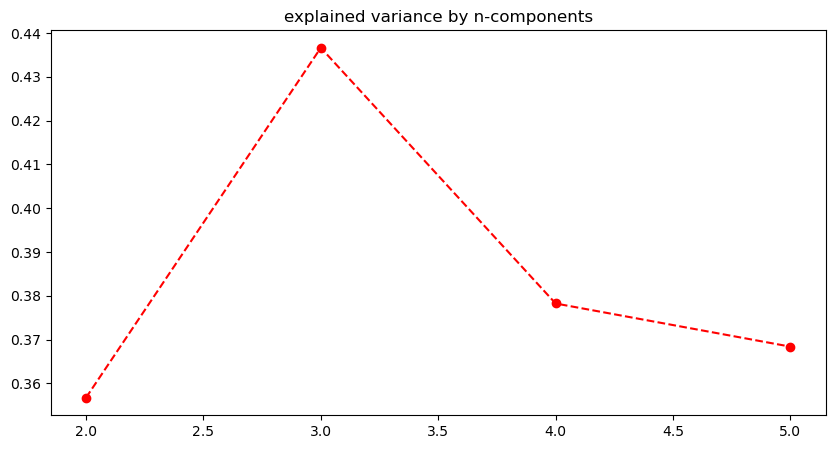

In [9]:
# 1 Star
# First step is to create a list containing each word found in the 1 star reviews. 
list_r1 = [d.split() for d in corpus_r1]

# The dictionary is the created of all words that show up in at least one document\review in the corpus.
dictionary_r1 = corpora.Dictionary(list_r1)

# convert corpus into a bag of words for LSA
lsa_bow_r1 = [dictionary_r1.doc2bow(text) for text in list_r1]


# Start of LSI
# List to obtain the coherence scores of each number of clusters. 
performance_r1 = []


# find the coherence score with a different number of topics
for i in range(2,6):
    lsi = LsiModel(lsa_bow_r1, num_topics=i, id2word=dictionary_r1, random_seed=42, extra_samples=5, power_iters=5)
    coherence_model = CoherenceModel(model=lsi, texts=review_1s['Review clean'], dictionary=dictionary_r1, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    performance_r1.append(coherence_score)

# Plot our coherence scores in accordance to the number of topics
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2,6), performance_r1, 'ro--')
plt.title('explained variance by n-components')

### 3.3.  Use best model to find word distributions of the reviews

In [10]:
# From the above graph it looks like our optimal number of topics is 4.
# perform SVD on our Term document matrix with the LsiModel to extract 4 topics
lsi = LsiModel(lsa_bow_r1, num_topics=4, id2word=dictionary_r1, extra_samples=5, power_iters=5)

"""
Truncated Singular Value Decomposition (SVD) takes in a matrix M and decomposes the matrix into 3 matrices called U, V and S.

U relates terms to topics
V relates documents to topics
S is a diagonal matrix of singular values which are sorted from most important (largest value) topic to 
least important (smallest) topic

Then it reduces the matrices into k dimensions where k is a number specified by the user. K is the number of topics.
"""

# find the 6 words with the strongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=6):
    print('Topic {}: {}.'.format(topic_num, words))
    
# The topics that you see in the output is ranked from most important, topic 0, to least important, topic 4
# Remeber, these topics are purely a collection of similar words.

Topic 0: 0.281*"drink" + 0.271*"customer" + 0.261*"time" + 0.214*"order" + 0.206*"service" + 0.199*"rude".
Topic 1: 0.526*"puff" + 0.454*"cream" + 0.236*"hair" + -0.203*"rude" + -0.152*"customer" + -0.137*"double".
Topic 2: 0.418*"drink" + -0.235*"food" + 0.220*"puff" + -0.189*"sandwich" + -0.153*"service" + 0.153*"cream".
Topic 3: -0.516*"drink" + 0.267*"rude" + 0.222*"puff" + 0.198*"double" + 0.193*"cream" + 0.188*"customer".


### 2 Star reviews LSA

### 3.2.  Model creation and evaluation

Coherence score with 2 clusters: 0.6004940269313559
Coherence score with 3 clusters: 0.40637436007108
Coherence score with 4 clusters: 0.5151867122250494
Coherence score with 5 clusters: 0.5542293023213596


Text(0.5, 1.0, 'explained variance by n-components')

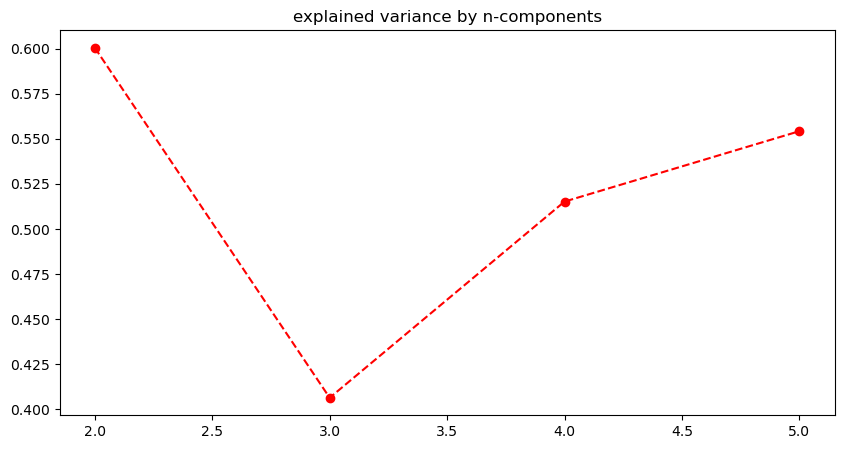

In [11]:
# 2 Star
# First step is to create a list containing each word found in the 2 star reviews. 
list_r2 = [d.split() for d in corpus_r2]

# The dictionary is the created of all words that show up in at least one document\review in the corpus.
dictionary_r2 = corpora.Dictionary(list_r2)

# convert corpus into a bag of words for LSA
lsa_bow_r2 = [dictionary_r2.doc2bow(text) for text in list_r2]


# Start of LSI
# List to obtain the coherence scores of each number of clusters. 
performance_r2 = []


# find the coherence score with a different number of topics
for i in range(2,6):
    lsi = LsiModel(lsa_bow_r2, num_topics=i, id2word=dictionary_r2, random_seed=42, extra_samples=5, power_iters=5)
    coherence_model = CoherenceModel(model=lsi, texts=review_2s['Review clean'], dictionary=dictionary_r2, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    performance_r2.append(coherence_score)

# Plot our coherence scores in accordance to the number of topics
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2,6), performance_r2, 'ro--')
plt.title('explained variance by n-components')

### 3.3.  Use best model to find word distributions of the reviews

In [12]:
# From the above graph it looks like our optimal number of topics is 2.
# perform SVD on our Term document matrix with the LsiModel to extract 2 topics
lsi = LsiModel(lsa_bow_r2, num_topics=2, id2word=dictionary_r2, random_seed=42, extra_samples=5, power_iters=5)

# find the 6 words with the strongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=6):
    print('Words in topic {}: {}.'.format(topic_num, words))
    
# The topics that you see in the output is ranked from most important, topic 0, to least important, topic 4
# Remeber, these topics are purely a collection of similar words.

Words in topic 0: 0.352*"drink" + 0.262*"time" + 0.245*"order" + 0.225*"shop" + 0.165*"people".
Words in topic 1: 0.271*"order" + -0.260*"shake" + 0.208*"customer" + -0.198*"ordered" + -0.184*"cream".


### 3 Star reviews LSA

### 3.2.  Model creation and evaluation

Coherence score with 2 clusters: 0.5231152101199612
Coherence score with 3 clusters: 0.4469425126160238
Coherence score with 4 clusters: 0.49040186007047903
Coherence score with 5 clusters: 0.4303404603133506


Text(0.5, 1.0, 'explained variance by n-components')

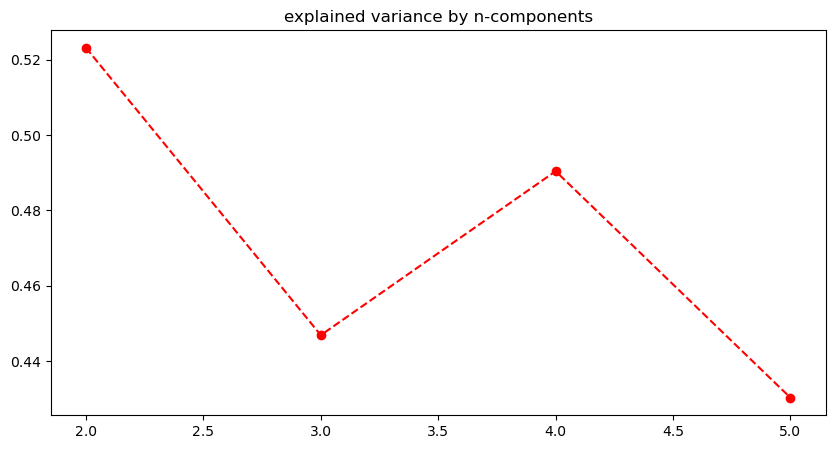

In [13]:
# 3 Star
# First step is to create a list containing each word found in the 3 star reviews. 
list_r3 = [d.split() for d in corpus_r3]

# The dictionary is the created of all words that show up in at least one document\review in the corpus.
dictionary_r3 = corpora.Dictionary(list_r3)

# convert corpus into a bag of words for LSA
lsa_bow_r3 = [dictionary_r3.doc2bow(text) for text in list_r3]


# Start of LSI
# List to obtain the coherence scores of each number of clusters. 
performance_r3 = []


# find the coherence score with a different number of topics
for i in range(2,6):
    lsi = LsiModel(lsa_bow_r3, num_topics=i, id2word=dictionary_r3, random_seed=42, extra_samples=5, power_iters=5)
    coherence_model = CoherenceModel(model=lsi, texts=review_3s['Review clean'], dictionary=dictionary_r3, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    performance_r3.append(coherence_score)

# Plot our coherence scores in accordance to the number of topics
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2,6), performance_r3, 'ro--')
plt.title('explained variance by n-components')

### 3.3.  Use best model to find word distributions of the reviews

In [14]:
# From the above graph it looks like our optimal number of topics is 5.
# perform SVD on our Term document matrix with the LsiModel to extract 5 topics
lsi = LsiModel(lsa_bow_r3, num_topics=2, id2word=dictionary_r3, random_seed=42, extra_samples=5, power_iters=5)

# find the 6 words with the strongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=6):
    print('Words in topic {}: {}.'.format(topic_num, words))
    
# The topics that you see in the output is ranked from most important, topic 0, to least important, topic 4
# Remeber, these topics are purely a collection of similar words.

Words in topic 0: 0.276*"shop" + 0.226*"latte" + 0.215*"time" + 0.208*"pretty" + 0.205*"people".
Words in topic 1: -0.346*"people" + 0.310*"latte" + -0.201*"counter" + 0.158*"pretty" + -0.156*"bean".


### 4 Star reviews LSA

### 3.2.  Model creation and evaluation

Coherence score with 2 clusters: 0.2864707023883929
Coherence score with 3 clusters: 0.554586864511437
Coherence score with 4 clusters: 0.43980190650106266
Coherence score with 5 clusters: 0.5089478559198817


Text(0.5, 1.0, 'explained variance by n-components')

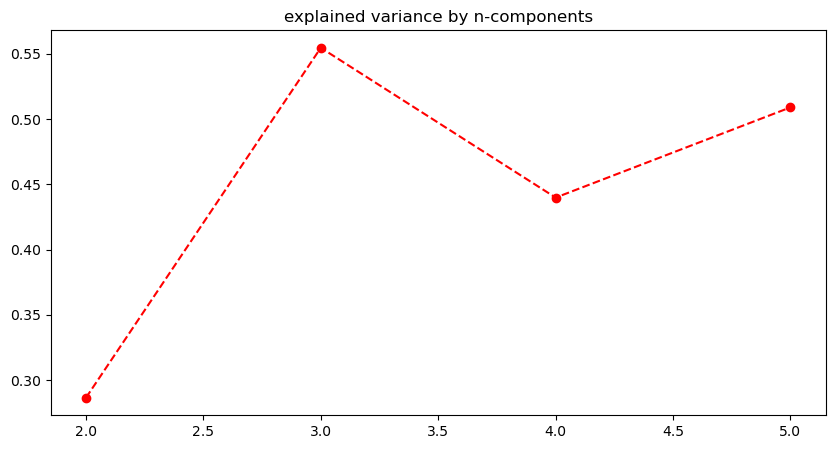

In [15]:
# 4 Star
# First step is to create a list containing each word found in the 4 star reviews. 
list_r4 = [d.split() for d in corpus_r4]

# The dictionary is the created of all words that show up in at least one document\review in the corpus.
dictionary_r4 = corpora.Dictionary(list_r4)

# convert corpus into a bag of words for LSA
lsa_bow_r4 = [dictionary_r4.doc2bow(text) for text in list_r4]


# Start of LSI
# List to obtain the coherence scores of each number of clusters. 
performance_r4 = []


# find the coherence score with a different number of topics
for i in range(2,6):
    lsi = LsiModel(lsa_bow_r4, num_topics=i, id2word=dictionary_r4, random_seed=42, extra_samples=5, power_iters=5)
    coherence_model = CoherenceModel(model=lsi, texts=review_4s['Review clean'], dictionary=dictionary_r4, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    performance_r4.append(coherence_score)

# Plot our coherence scores in accordance to the number of topics
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2,6), performance_r4, 'ro--')
plt.title('explained variance by n-components')

### 3.3.  Use best model to find word distributions of the reviews

In [16]:
# From the above graph it looks like our optimal number of topics is 4.
# perform SVD on our Term document matrix with the LsiModel to extract 4 topics
lsi = LsiModel(lsa_bow_r4, num_topics=3, id2word=dictionary_r4 , random_seed=42, extra_samples=5, power_iters=5)

# find the 6 words with the strongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=6):
    print('Words in topic {}: {}.'.format(topic_num, words))
    
# The topics that you see in the output is ranked from most important, topic 0, to least important, topic 4
# Remeber, these topics are purely a collection of similar words.

Words in topic 0: 0.260*"check" + 0.259*"drink" + 0.231*"latte" + 0.177*"time" + 0.172*"moon" + 0.159*"nice".
Words in topic 1: 0.658*"monkey" + 0.440*"nest" + -0.189*"moon" + 0.166*"know" + -0.117*"milk" + -0.104*"drink".
Words in topic 2: -0.647*"moon" + -0.248*"milk" + -0.213*"summer" + -0.155*"espresso" + -0.126*"monkey" + -0.124*"sweet".


### 5 Star reviews LSA

### 3.2.  Model creation and evaluation

Coherence score with 2 clusters: 0.4071881819438966
Coherence score with 3 clusters: 0.5168661930362362
Coherence score with 4 clusters: 0.49803040346540817
Coherence score with 5 clusters: 0.4696800056355405


Text(0.5, 1.0, 'explained variance by n-components')

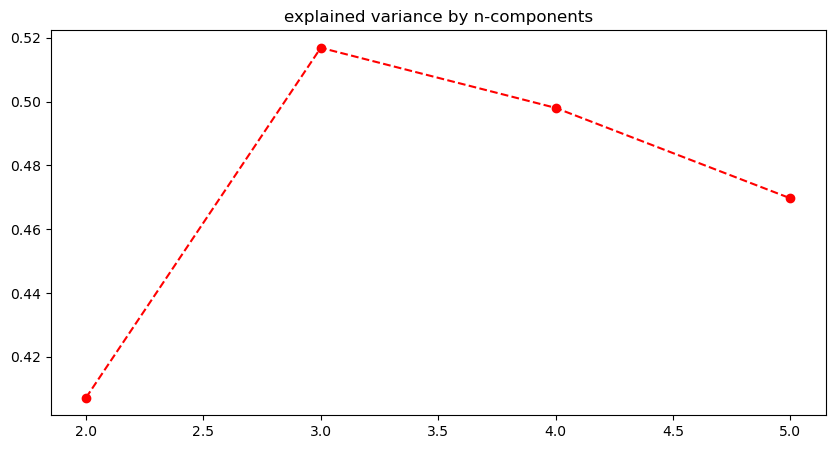

In [17]:
# 5 Star
# First step is to create a list containing each word found in the 5 star reviews. 
list_r5 = [d.split() for d in corpus_r5]

# The dictionary is the created of all words that show up in at least one document\review in the corpus.
dictionary_r5 = corpora.Dictionary(list_r5)

# convert corpus into a bag of words for LSA
lsa_bow_r5 = [dictionary_r5.doc2bow(text) for text in list_r5]


# Start of LSI
# List to obtain the coherence scores of each number of clusters. 
performance_r5 = []


# find the coherence score with a different number of topics
for i in range(2,6):
    lsi = LsiModel(lsa_bow_r5, num_topics=i, id2word=dictionary_r5, random_seed=42, extra_samples=5, power_iters=5)
    coherence_model = CoherenceModel(model=lsi, texts=review_5s['Review clean'], dictionary=dictionary_r5, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    performance_r5.append(coherence_score)

# Plot our coherence scores in accordance to the number of topics
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2,6), performance_r5, 'ro--')
plt.title('explained variance by n-components')

### 3.3.  Use best model to find word distributions of the reviews

In [18]:
# From the above graph it looks like our optimal number of topics is 5.
# perform SVD on our Term document matrix with the LsiModel to extract 5 topics
lsi = LsiModel(lsa_bow_r5, num_topics=3, id2word=dictionary_r5, random_seed=42, extra_samples=5, power_iters=5)

# find the 6 words with the strongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=6):
    print('Words in topic {}: {}.'.format(topic_num, words))
    
# The topics that you see in the output is ranked from most important, topic 0, to least important, topic 2
# Remeber, these topics are purely a collection of similar words.

Words in topic 0: 0.399*"moon" + 0.337*"latte" + 0.248*"milk" + 0.206*"shop" + 0.199*"drink" + 0.197*"check".
Words in topic 1: -0.641*"moon" + -0.307*"milk" + -0.214*"summer" + 0.168*"time" + -0.153*"half" + 0.136*"shop".
Words in topic 2: 0.568*"latte" + -0.248*"waffle" + 0.200*"vanilla" + 0.190*"lavender" + 0.163*"cute" + -0.160*"space".


*** 

***

# Step 4

## LDA
This algorithm aims to classify each document as a distibution of topics and each topic as a distribution of words. Basically, this will tell us how much of each topic is needed to re-create the document\review.

This approach uses the bag of words method. It is possible to use TF-IDf, although it is more computationally intensive and I found that the results is not much better in this example.

### 4.1.  Make Bigrams and Trigrams of all the words in the 1 star reviews
### 4.2.  Create dictionary containing each word and the number of times that word appears

In [20]:
list_lda_1 = [d.split() for d in corpus_r1]

bigram1 = gensim.models.Phrases(list_lda_1, min_count=3, threshold=50)
trigram1 = gensim.models.Phrases(bigram1[list_lda_1], threshold=50)

bigram_mod1 = gensim.models.phrases.Phraser(bigram1)
trigram_mod1 = gensim.models.phrases.Phraser(trigram1)

def make_bigrams(texts):
    return [bigram_mod1[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram1[bigram_mod1[doc]] for doc in texts]

data_bigrams1 = make_bigrams(list_lda_1)
data_processed1 = make_trigrams(data_bigrams1)

# Create dictionary and corpus needed for topic modeling
# dictionary is a mapping of word_id --> word, as the variable name implies
id2word1 = corpora.Dictionary(data_processed1)

# the preprocessed and lemmatized documents themselves
texts1 = data_processed1

# corpus is a mapping of word_id --> word frequency
corpus1 = [id2word1.doc2bow(text) for text in texts1]
print('This is how our data is viewed by computer:')
print(corpus1[:1])

# Human readable format of corpus (term-frequency)
print('\nHuman readable format:')
print([[(id2word1[id], freq) for id, freq in cp] for cp in corpus1[:1]])

This is how our data is viewed by computer:
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 3), (21, 2), (22, 1), (23, 1), (24, 1), (25, 2), (26, 2), (27, 1), (28, 4), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]

Human readable format:
[[('absolutely', 1), ('begin', 1), ('bigger', 1), ('comparable', 1), ('considering', 1), ('correctly', 1), ('decrease', 1), ('difficult', 1), ('drink', 1), ('especially', 1), ('fabulous', 2), ('factory', 1), ('figured', 1), ('friend', 1), ('getting', 1), ('hopefully', 1), ('iced', 1), ('inflated', 1), ('large', 2), ('lead', 1), ('mint', 3), ('mojito', 2), ('okay', 1), ('ordering', 1), ('ounce', 1), ('particularly', 2), ('philz', 2), ('pick', 1), ('price', 4), ('recommend', 1), ('remember', 1), ('self', 1), ('service', 1), ('shocked', 1), ('taste', 1), ('trying', 1), ('unde

### 4.3.  Wordclouds with processed data
A wordcloud is a collection of words illustrated through the use of an image. We can display the most common words found in each review corpus.

It allows us to display and retain information musch more easily. The wordclouds created here, uses the 50 most common terms which appears in each of the different corpuses.

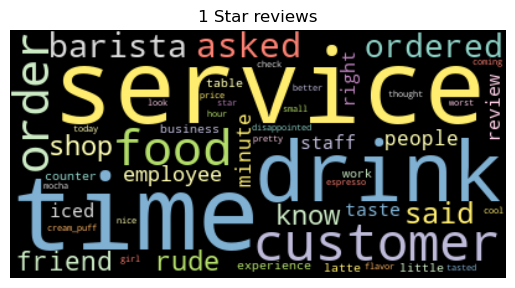

In [21]:
# Create lists containing the individual words from 1 star review ratings, icluding Bi/Tri-grams
wc1 = []
for i in data_processed1:
    for j in i:
        wc1.append(j)
    
# Count individual word occurances
counts = Counter(wc1)

# create the WordCloud object
wordcloud = WordCloud(min_word_length =3,
                      background_color='black',
                     colormap='Set3')

# generate the word cloud
wordcloud.generate_from_frequencies(dict(counts.most_common(50)))

#plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('1 Star reviews')
plt.show()

### 4.4.  Run LDA model and find best number of clusters, visualizing Coherence scores

Coherence score with 2 clusters: 0.28019035171301276
Perplexity:  -7.62
Coherence score with 3 clusters: 0.32966734034327055
Perplexity:  -7.67
Coherence score with 4 clusters: 0.48303452678170455
Perplexity:  -7.7
Coherence score with 5 clusters: 0.48151486705135793
Perplexity:  -7.74
Coherence score with 6 clusters: 0.4146074992901409
Perplexity:  -7.78


Text(0.5, 1.0, 'explained variance by n-components')

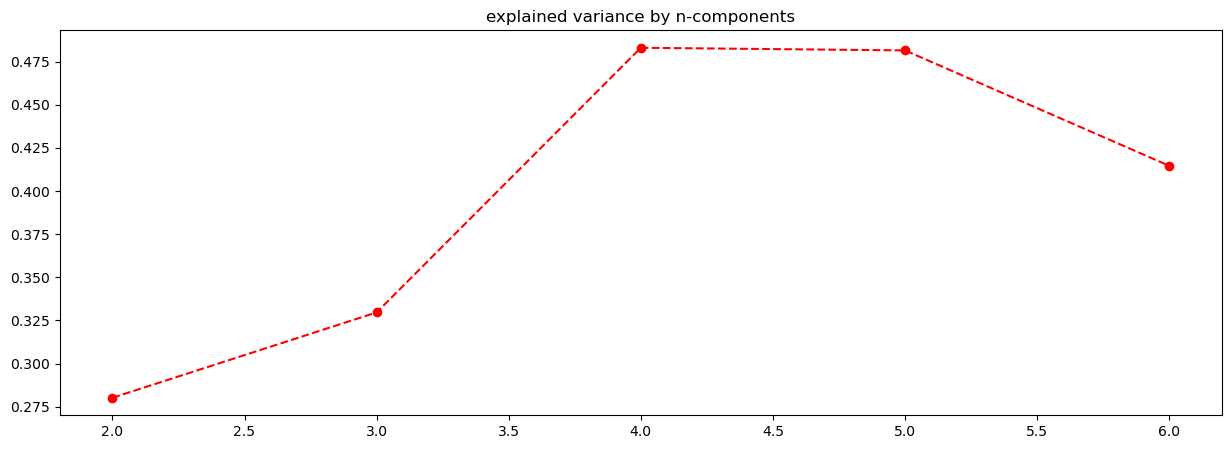

In [24]:
# List that contains coherence scores
performance_lda_1 = []

print('Coherence scores is the amount (in %) that the clusters can explain of the document.'
      'The higher the coherence score, the more does the model understand of the documents, which is our Reviews')
print('')

# find the coherence score with a different number of topics
for i in range(2,7):
    lda = LdaModel(corpus=corpus1,id2word=id2word1,num_topics=i, random_state=42, alpha=1, eta=1 , passes=10,chunksize=10)
    coherence_model = CoherenceModel(model=lda, texts=data_processed1, dictionary=id2word1, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    performance_lda_1.append(coherence_score)
    # Compute Perplexity (lower is better)
    print('Perplexity: ', round(lda.log_perplexity(corpus1), 2))

    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2,7), performance_lda_1, 'ro--')
plt.title('explained variance by n-components')

### 4.5.  Create the best LDA model using cluster with highest coherence score and find the Topic-Word distribution for each topic

In [25]:
# Create LDA model with 4 topics.
lda_1 = LdaModel(corpus=corpus1,id2word=id2word1,num_topics=4, random_state=42,alpha=1, eta=1 , passes=10,chunksize=10)

# find the 6 words with the srongest association to the derived topics
for topic_num, words in lda_1.print_topics(num_words=6):
    print('Words in topic {}: {}.'.format(topic_num, words))

Words in topic 0: 0.013*"time" + 0.009*"service" + 0.009*"drink" + 0.008*"customer" + 0.007*"ordered" + 0.006*"order".
Words in topic 1: 0.002*"accidentally" + 0.002*"asleep" + 0.002*"studying" + 0.002*"strange" + 0.002*"brew" + 0.002*"breakfast_taco".
Words in topic 2: 0.021*"food" + 0.007*"sandwich" + 0.004*"burger" + 0.003*"hair" + 0.003*"salad" + 0.003*"lunch".
Words in topic 3: 0.002*"store" + 0.002*"stained" + 0.002*"bathroom" + 0.002*"filthy" + 0.002*"urine" + 0.002*"sunglass".


### 4.6.  Document-Topic assignment and visualization
We can assign each document to a main topic and view the distribution of how the topics might then be able to create the document.

Text(0.5, 1.0, 'Documents per Topic')

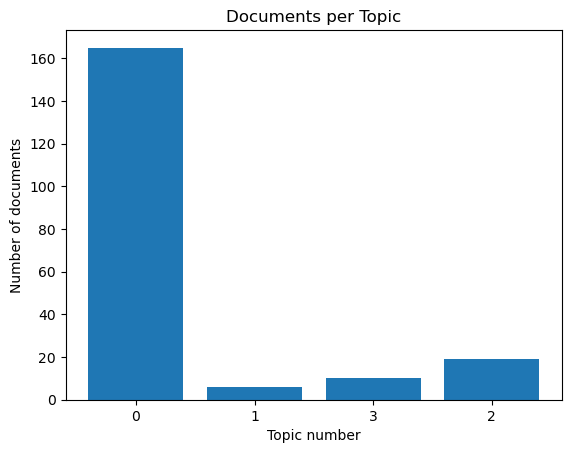

In [26]:
# Create a list that stores the main topic of each document.
topics_rating1 = []

# Go through each document from the 1 star corpus, and assign the main topic to the document
for i in range (len(corpus1)):
    # Get each document from the corpus and extract the topic distributions
    number = lda_1.get_document_topics(corpus1[i])
    topic = max(dict(number), key=dict(number).get)
    
    # We can print out the document topic as well as the document-topic distribution
    # print(f'From 1 star corpus, document {i} belongs mainly to Topic {topic}.')
    # print(f'Document {i} has the following "Topic-Value" distributions: {dict(number)}\n')
    
    # Add topic number of each document, used for plotting.
    topics_rating1.append(topic)
    
# Create dictionary containing the topic numbers and the number of documents for each topic
document_topic_count_1 = dict(Counter(topics_rating1))

# PLot the number of documents for each topic
plt.bar(range(len(document_topic_count_1)), list(document_topic_count_1.values()), align='center')
plt.xticks(range(len(document_topic_count_1)), list(document_topic_count_1.keys()))
plt.ylabel('Number of documents')
plt.xlabel('Topic number')
plt.title('Documents per Topic')

### 4.7.  1 Star results interpretation

- As we can see from the 1 star reviews it is clear that topic '0' has the overwhelming majority of reviews. If we take a look at topic 0 , we have the following key-words: "time, service, drink, customer, ordered, order". 

By looking at these key-words, it is clear that 'Time ordered' and 'Customer service are the main problems and that it might be beneficial for the restuarants to start looking into these problems.

- The next Topic is topic 2, with the keywords: "food, sandwich, burger, hair, salad, lunch".

By looking at these keywords, it is clear that the 'Food' of the restuarants is being talked about alot. Knowing that these keywords are from the 1 star reviews, it is probably not so good. Therefore, the restuarants have to look at their food quality.

***

## 2 Star reviews LDA
### 4.1.  Make Bigrams and Trigrams of all the words in the 1 star reviews
### 4.2.  Create dictionary containing each word and the number of times that word appears

In [27]:
list_lda_2 = [d.split() for d in corpus_r2]
list_lda_2[:1]

bigram2 = gensim.models.Phrases(list_lda_2, min_count=3, threshold=50)
trigram2 = gensim.models.Phrases(bigram2[list_lda_2], threshold=50)

bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
trigram_mod2 = gensim.models.phrases.Phraser(trigram2)

def make_bigrams(texts):
    return [bigram_mod2[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram2[bigram_mod2[doc]] for doc in texts]

data_bigrams2 = make_bigrams(list_lda_2)
data_processed2 = make_trigrams(data_bigrams2)

# Create dictionary and corpus needed for topic modeling
# dictionary is a mapping of word_id --> word, as the variable name implies
id2word2 = corpora.Dictionary(data_processed2)

# the preprocessed and lemmatized documents themselves
texts2 = data_processed2

# corpus is a mapping of word_id --> word frequency
corpus2 = [id2word2.doc2bow(text) for text in texts2]
#print(corpus2[:1])

# Human readable format of corpus (term-frequency)
#[[(id2word2[id], freq) for id, freq in cp] for cp in corpus2[:1]]

### 4.3.  Wordclouds with processed data

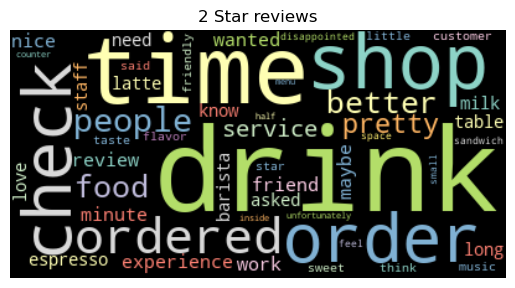

In [28]:
# Create lists containing the individual words from 2 star review ratings, icluding Bi/Tri-grams
wc2 = []
for i in data_processed2:
    for j in i:
        wc2.append(j)
    
# Count individual word occurances
counts = Counter(wc2)

# create the WordCloud object
wordcloud = WordCloud(min_word_length =3,
                      background_color='black',
                     colormap='Set3')

# generate the word cloud
wordcloud.generate_from_frequencies(dict(counts.most_common(50)))

#plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('2 Star reviews')
plt.show()

### 4.4.  Run LDA model and find best number of clusters, visualizing Coherence scores

Coherence score with 2 clusters: 0.35976325415476673
Perplexity:  -7.61
Coherence score with 3 clusters: 0.3292120934831595
Perplexity:  -7.66
Coherence score with 4 clusters: 0.4277731558079123
Perplexity:  -7.71
Coherence score with 5 clusters: 0.4366728279678009
Perplexity:  -7.75
Coherence score with 6 clusters: 0.35883241982364517
Perplexity:  -7.78


Text(0.5, 1.0, 'explained variance by n-components')

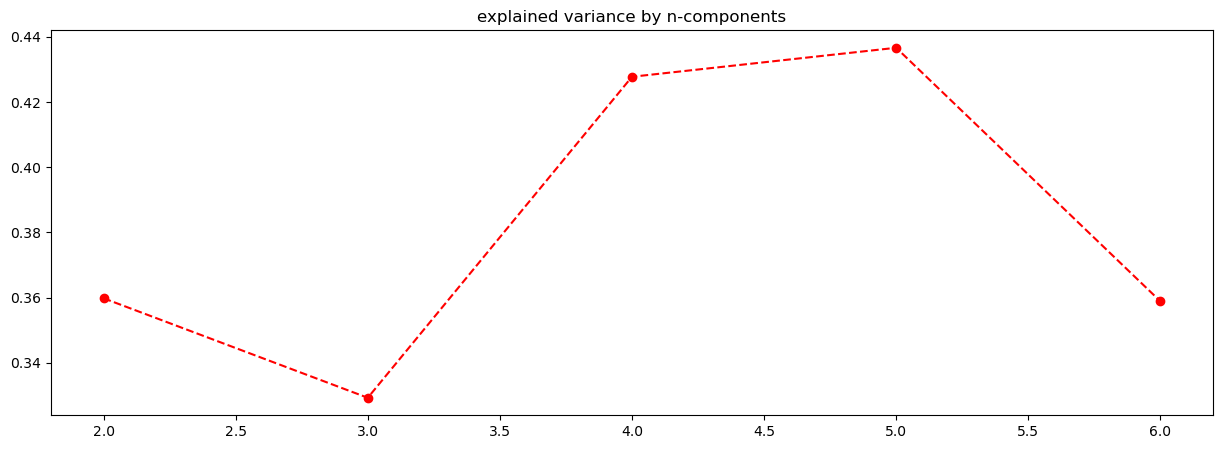

In [29]:
performance_lda_2 = []


# find the coherence score with a different number of topics
for i in range(2,7):
    lda = LdaModel(corpus=corpus2, id2word=id2word2, num_topics=i, random_state=42, alpha=1, eta=1 , passes=10, chunksize=10)
    # Compute coherence scores
    coherence_model = CoherenceModel(model=lda, texts=data_processed2, dictionary=id2word2, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    performance_lda_2.append(coherence_score)
    # Compute Perplexity (lower is better)
    print('Perplexity: ', round(lda.log_perplexity(corpus2), 2))

    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2,7), performance_lda_2, 'ro--')
plt.title('explained variance by n-components')

### 4.5.  Create the best LDA model using cluster with highest coherence score and find the Topic-Word distribution for each topic

In [30]:
# Create LDA model with 5 topics.
lda_2 = LdaModel(corpus=corpus2,id2word=id2word2,num_topics=5, random_state=42,alpha=1, eta=1 , passes=10,chunksize=10)

# find the 6 words with the srongest association to the derived topics
for topic_num, words in lda_2.print_topics(num_words=6):
    print('Words in topic {}: {}.'.format(topic_num, words))

Words in topic 0: 0.002*"irie" + 0.001*"lola" + 0.001*"radiohead" + 0.001*"committed" + 0.001*"reggae" + 0.001*"grove".
Words in topic 1: 0.005*"cream" + 0.005*"milk" + 0.005*"maybe" + 0.005*"toast" + 0.005*"espresso" + 0.005*"potato".
Words in topic 2: 0.001*"irie" + 0.001*"lola" + 0.001*"houndstooth" + 0.001*"expensive" + 0.001*"larger" + 0.001*"lounge".
Words in topic 3: 0.012*"drink" + 0.010*"time" + 0.010*"shop" + 0.009*"check" + 0.008*"order" + 0.007*"people".
Words in topic 4: 0.003*"event" + 0.002*"fair" + 0.002*"charity" + 0.002*"festival" + 0.002*"booked" + 0.002*"irie".


### 2 Star reviews Document-Topic assignment and visualization
We can assign each document to a main topic and view the distribution of how the topics might then be able to create the document.

### 4.6.  Document-Topic assignment and visualization

Text(0.5, 1.0, 'Documents per Topic')

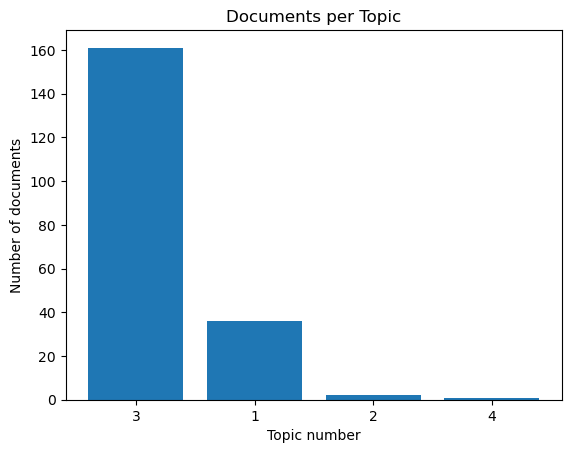

In [31]:
# Create a list that stores the main topic of each document.
topics_rating2 = []

# Go through each document from the 2 star corpus, and assign the main topic to the document
for i in range (len(corpus2)):
    # Get each document from the corpus and extract the topic distributions
    number = lda_2.get_document_topics(corpus2[i])
    topic = max(dict(number), key=dict(number).get)
    
    # We can print out the document topic as well as the document-topic distribution
    # print(f'From 2 star corpus, document {i} belongs mainly to Topic {topic}.')
    # print(f'Document {i} has the following "Topic-Value" distributions: {dict(number)}\n')
    
    # Add topic number of each document, used for plotting.
    topics_rating2.append(topic)
    
# Create dictionary containing the topic numbers and the number of documents for each topic
document_topic_count_2 = dict(Counter(topics_rating2))

# PLot the number of documents for each topic
plt.bar(range(len(document_topic_count_2)), list(document_topic_count_2.values()), align='center')
plt.xticks(range(len(document_topic_count_2)), list(document_topic_count_2.keys()))
plt.ylabel('Number of documents')
plt.xlabel('Topic number')
plt.title('Documents per Topic')

### 2 Star results interpretation

Based on the graph above it is clear that the majority of the 2 star reviews belongs to topic 3. The keywords in topic 3 are: "drink, time, shop, check, order, people". 

From the keywords we might extract the following, 1. People seem to be complaining about the drinks, 2. People complain about the time, which might be the time to order and the time that customers had to wait to recieve their checks. This relates alot to the 1 star reviews, in that the customer service might be bad, and that their product quality seems to be lacking.

***

## 3 Star reviews LDA
### 4.1.  Make Bigrams and Trigrams of all the words in the 1 star reviews
### 4.2.  Create dictionary containing each word and the number of times that word appears

In [32]:
list_lda_3 = [d.split() for d in corpus_r3]
list_lda_3[:1]

bigram3 = gensim.models.Phrases(list_lda_3, min_count=3, threshold=50)
trigram3 = gensim.models.Phrases(bigram3[list_lda_3], threshold=50)

bigram_mod3 = gensim.models.phrases.Phraser(bigram3)
trigram_mod3 = gensim.models.phrases.Phraser(trigram3)

def make_bigrams(texts):
    return [bigram_mod3[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram3[bigram_mod3[doc]] for doc in texts]

data_bigrams3 = make_bigrams(list_lda_3)
data_processed3 = make_trigrams(data_bigrams3)

# Create dictionary and corpus needed for topic modeling
# dictionary is a mapping of word_id --> word, as the variable name implies
id2word3 = corpora.Dictionary(data_processed3)

# the preprocessed and lemmatized documents themselves
texts3 = data_processed3

# corpus is a mapping of word_id --> word frequency
corpus3 = [id2word3.doc2bow(text) for text in texts3]
#print(corpus3[:1])

# Human readable format of corpus (term-frequency)
#[[(id2word3[id], freq) for id, freq in cp] for cp in corpus3[:1]]

### 4.3.  Wordclouds with processed data

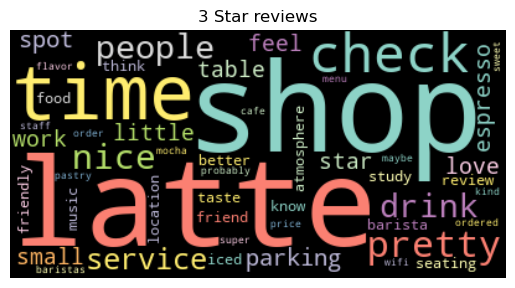

In [33]:
# Create lists containing the individual words from 3 star review ratings, icluding Bi/Tri-grams
wc3 = []
for i in data_processed3:
    for j in i:
        wc3.append(j)
    
# Count individual word occurances
counts = Counter(wc3)

# create the WordCloud object
wordcloud = WordCloud(min_word_length =3,
                      background_color='black',
                     colormap='Set3')

# generate the word cloud
wordcloud.generate_from_frequencies(dict(counts.most_common(50)))

#plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('3 Star reviews')
plt.show()

### 4.4.  Run LDA model and find best number of clusters, visualizing Coherence scores

Coherence score with 2 clusters: 0.33708385612780023
Perplexity:  -7.51
Coherence score with 3 clusters: 0.3615004843247243
Perplexity:  -7.56
Coherence score with 4 clusters: 0.4676905031454083
Perplexity:  -7.61
Coherence score with 5 clusters: 0.4871943695127595
Perplexity:  -7.67
Coherence score with 6 clusters: 0.38933580108481874
Perplexity:  -7.68


Text(0.5, 1.0, 'explained variance by n-components')

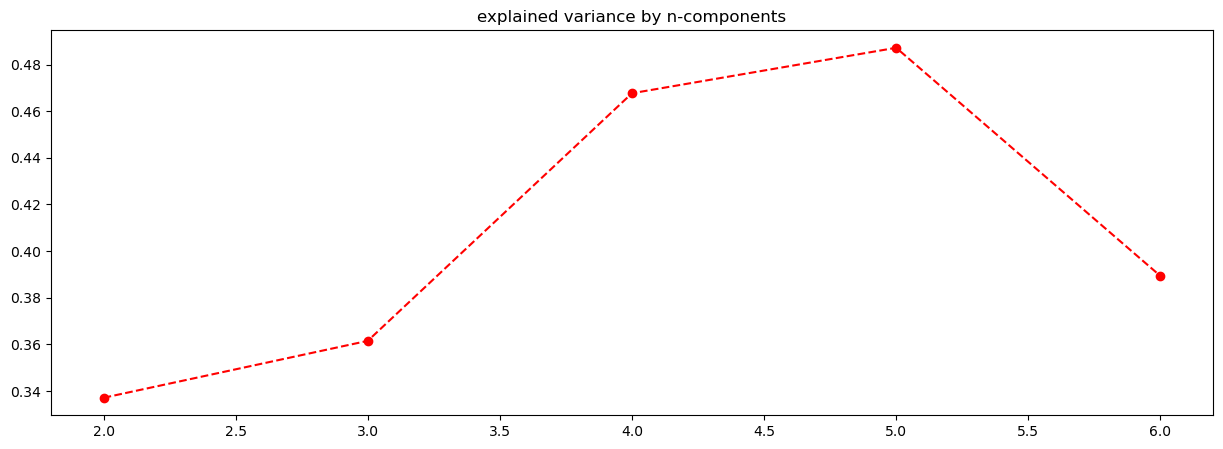

In [34]:
performance_lda_3 = []


# find the coherence score with a different number of topics
for i in range(2,7):
    lda = LdaModel(corpus=corpus3, id2word=id2word3, num_topics=i, random_state=42, alpha=1, eta=1 , passes=10, chunksize=10)
    # Compute coherence scores
    coherence_model = CoherenceModel(model=lda, texts=data_processed3, dictionary=id2word3, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    performance_lda_3.append(coherence_score)
    # Compute Perplexity (lower is better)
    print('Perplexity: ', round(lda.log_perplexity(corpus3), 2))

    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2,7), performance_lda_3, 'ro--')
plt.title('explained variance by n-components')

### 4.5.  Create the best LDA model using cluster with highest coherence score and find the Topic-Word distribution for each topic

In [35]:
# Create LDA model with 5 topics.
lda_3 = LdaModel(corpus=corpus3,id2word=id2word3,num_topics=5, random_state=42,alpha=1, eta=1 , passes=10,chunksize=10)

# find the 6 words with the srongest association to the derived topics
for topic_num, words in lda_3.print_topics(num_words=6):
    print('Words in topic {}: {}.'.format(topic_num, words))

Words in topic 0: 0.001*"bennu" + 0.001*"caffe_medici" + 0.001*"fuck" + 0.001*"blend" + 0.001*"green" + 0.001*"cuvee".
Words in topic 1: 0.013*"latte" + 0.010*"drink" + 0.009*"espresso" + 0.005*"super" + 0.005*"taste" + 0.005*"milk".
Words in topic 2: 0.001*"bennu" + 0.001*"fuck" + 0.001*"green" + 0.001*"serving" + 0.001*"dining" + 0.001*"request".
Words in topic 3: 0.002*"chip" + 0.002*"wrap" + 0.002*"fuck" + 0.002*"restaurant" + 0.001*"mustard" + 0.001*"money".
Words in topic 4: 0.011*"people" + 0.009*"shop" + 0.009*"parking" + 0.009*"time" + 0.007*"nice" + 0.007*"table".


### 3 Star reviews Document-Topic assignment and visualization
We can assign each document to a main topic and view the distribution of how the topics might then be able to create the document.

### 4.6.  Document-Topic assignment and visualization

Text(0.5, 1.0, 'Documents per Topic')

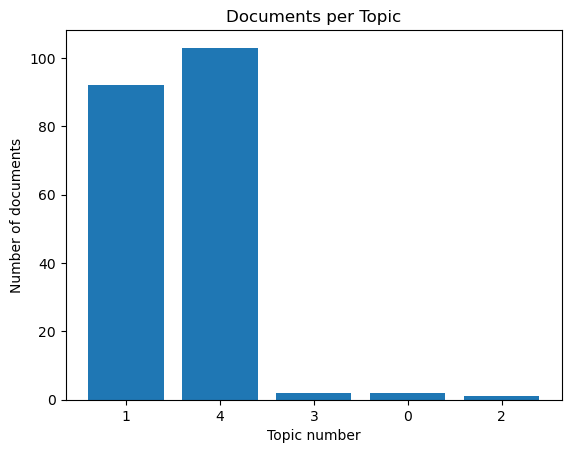

In [36]:
# Create a list that stores the main topic of each document.
topics_rating3 = []

# Go through each document from the 1 star corpus, and assign the main topic to the document
for i in range (len(corpus3)):
    # Get each document from the corpus and extract the topic distributions
    number = lda_3.get_document_topics(corpus3[i])
    topic = max(dict(number), key=dict(number).get)
    
    # We can print out the document topic as well as the document-topic distribution
    # print(f'From 3 star corpus, document {i} belongs mainly to Topic {topic}.')
    # print(f'Document {i} has the following "Topic-Value" distributions: {dict(number)}\n')
    
    # Add topic number of each document, used for plotting.
    topics_rating3.append(topic)
    
# Create dictionary containing the topic numbers and the number of documents for each topic
document_topic_count_3 = dict(Counter(topics_rating3))

# PLot the number of documents for each topic
plt.bar(range(len(document_topic_count_3)), list(document_topic_count_3.values()), align='center')
plt.xticks(range(len(document_topic_count_3)), list(document_topic_count_3.keys()))
plt.ylabel('Number of documents')
plt.xlabel('Topic number')
plt.title('Documents per Topic')

### 4.7.  3 Star Results interpretation

- By the looks of the graph above, both topic 4 and 1 seems to be very close. The keywords in topic 4 are: "people, shop, parking, time, nice, table". 

Although it might not be apparant, when reviewg the reviews containing these keywords, most people seem to be talking about the restuarants infrastructure and surroundings. Some people are complaining about the parking, while others are complaining about the Shop, which is dirty (looking at the reviews), as well as some of the Tables that were dirty and possibly broken.

- The keywords in topic 1 are: "latte, drink, espresso, super, taste, milk". 

This might be more apparent, the reviews are referencing the 'Coffees', since these are Coffee shop reviews. It is clear that customers were definitely not happy with the taste of the  "Latte's" and "Espresso's". This makes it quite easy for the restuarants to know how to improve their shops.

***

## 4 Star reviews LDA
### 4.1.  Make Bigrams and Trigrams of all the words in the 1 star reviews
### 4.2.  Create dictionary containing each word and the number of times that word appears

In [37]:
list_lda_4 = [d.split() for d in corpus_r4]
list_lda_4[:1]

bigram4 = gensim.models.Phrases(list_lda_4, min_count=3, threshold=50)
trigram4 = gensim.models.Phrases(bigram4[list_lda_4], threshold=50)

bigram_mod4 = gensim.models.phrases.Phraser(bigram4)
trigram_mod4 = gensim.models.phrases.Phraser(trigram4)

def make_bigrams(texts):
    return [bigram_mod4[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram4[bigram_mod4[doc]] for doc in texts]

data_bigrams4 = make_bigrams(list_lda_4)
data_processed4 = make_trigrams(data_bigrams4)

# Create dictionary and corpus needed for topic modeling
# dictionary is a mapping of word_id --> word, as the variable name implies
id2word4 = corpora.Dictionary(data_processed4)

# the preprocessed and lemmatized documents themselves
texts4 = data_processed4

# corpus is a mapping of word_id --> word frequency
corpus4 = [id2word4.doc2bow(text) for text in texts4]
#print(corpus4[:1])

# Human readable format of corpus (term-frequency)
#[[(id2word4[id], freq) for id, freq in cp] for cp in corpus4[:1]]

### 4.3.  Wordclouds with processed data

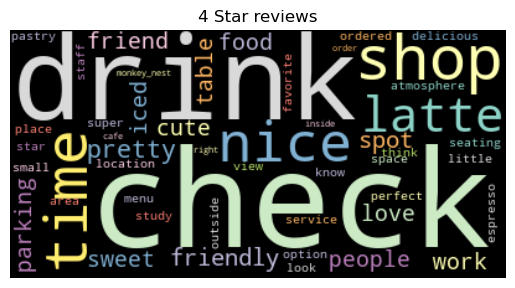

In [38]:
# Create lists containing the individual words from 3 star review ratings, icluding Bi/Tri-grams
wc4 = []
for i in data_processed4:
    for j in i:
        wc4.append(j)
    
# Count individual word occurances
counts = Counter(wc4)

# create the WordCloud object
wordcloud = WordCloud(min_word_length =3,
                      background_color='black',
                     colormap='Set3')

# generate the word cloud
wordcloud.generate_from_frequencies(dict(counts.most_common(50)))

#plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('4 Star reviews')
plt.show()

### 4.4.  Run LDA model and find best number of clusters, visualizing Coherence scores

Coherence score with 2 clusters: 0.3533261508606461
Perplexity:  -7.38
Coherence score with 3 clusters: 0.3481624196919802
Perplexity:  -7.43
Coherence score with 4 clusters: 0.3553989225713268
Perplexity:  -7.48
Coherence score with 5 clusters: 0.46462612146194243
Perplexity:  -7.52
Coherence score with 6 clusters: 0.4641780381208595
Perplexity:  -7.56


Text(0.5, 1.0, 'explained variance by n-components')

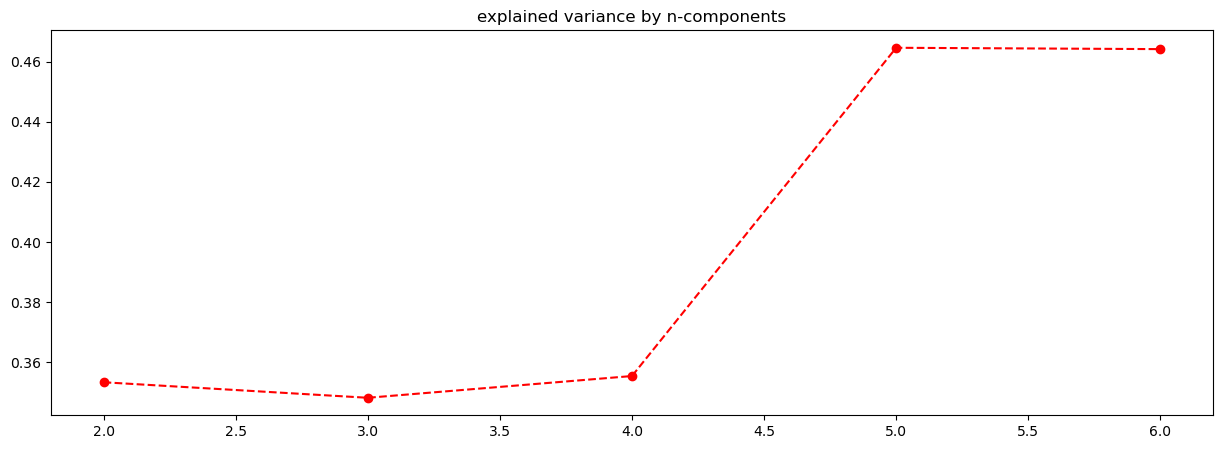

In [39]:
performance_lda_4 = []


# find the coherence score with a different number of topics
for i in range(2,7):
    lda = LdaModel(corpus=corpus4, id2word=id2word4, num_topics=i, random_state=42, alpha=1, eta=1 , passes=10, chunksize=10)
    # Compute coherence scores
    coherence_model = CoherenceModel(model=lda, texts=data_processed4, dictionary=id2word4, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    performance_lda_4.append(coherence_score)
    # Compute Perplexity (lower is better)
    print('Perplexity: ', round(lda.log_perplexity(corpus4), 2))

    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2,7), performance_lda_4, 'ro--')
plt.title('explained variance by n-components')

### 4.5.  Create the best LDA model using cluster with highest coherence score and find the Topic-Word distribution for each topic

In [40]:
# Create LDA model with 5 topics.
lda_4 = LdaModel(corpus=corpus4,id2word=id2word4,num_topics=5, random_state=42,alpha=1, eta=1 , passes=10,chunksize=10)

# find the 6 words with the srongest association to the derived topics
for topic_num, words in lda_4.print_topics(num_words=6):
    print('Words in topic {}: {}.'.format(topic_num, words))

Words in topic 0: 0.002*"domain" + 0.002*"nuptial_bliss" + 0.002*"rock_rose" + 0.001*"garage" + 0.001*"nearby" + 0.001*"issue".
Words in topic 1: 0.012*"drink" + 0.012*"check" + 0.011*"time" + 0.010*"shop" + 0.007*"friendly" + 0.007*"nice".
Words in topic 2: 0.001*"rock_rose" + 0.001*"corona" + 0.001*"neighborhood" + 0.001*"horchata" + 0.001*"hate" + 0.001*"beer".
Words in topic 3: 0.001*"rock_rose" + 0.001*"corona" + 0.001*"neighborhood" + 0.001*"horchata" + 0.001*"hate" + 0.001*"beer".
Words in topic 4: 0.001*"rock_rose" + 0.001*"corona" + 0.001*"neighborhood" + 0.001*"hate" + 0.001*"horchata" + 0.001*"beer".


### 4 Star reviews Document-Topic assignment and visualization
We can assign each document to a main topic and view the distribution of how the topics might then be able to create the document.

### 4.6.  Document-Topic assignment and visualization

Text(0.5, 1.0, 'Documents per Topic')

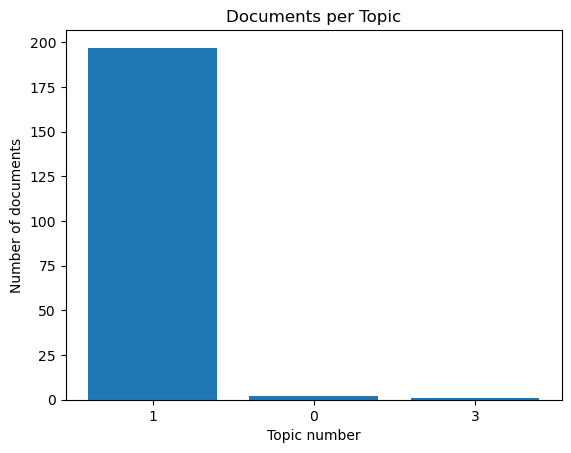

In [41]:
# Create a list that stores the main topic of each document.
topics_rating4 = []

# Go through each document from the 4 star corpus, and assign the main topic to the document
for i in range (len(corpus4)):
    # Get each document from the corpus and extract the topic distributions
    number = lda_4.get_document_topics(corpus4[i])
    topic = max(dict(number), key=dict(number).get)
    
    # We can print out the document topic as well as the document-topic distribution
    # print(f'From 4 star corpus, document {i} belongs mainly to Topic {topic}.')
    # print(f'Document {i} has the following "Topic-Value" distributions: {dict(number)}\n')
    
    # Add topic number of each document, used for plotting.
    topics_rating4.append(topic)
    
# Create dictionary containing the topic numbers and the number of documents for each topic
document_topic_count_4 = dict(Counter(topics_rating4))

# PLot the number of documents for each topic
plt.bar(range(len(document_topic_count_4)), list(document_topic_count_4.values()), align='center')
plt.xticks(range(len(document_topic_count_4)), list(document_topic_count_4.keys()))
plt.ylabel('Number of documents')
plt.xlabel('Topic number')
plt.title('Documents per Topic')

### 4.7.  4 Star Results interpretation

The graph above has so far been the standout, with topic 1 being the clear winner. Topic 1's keywords are: "drink, check, time, shop, friendly, nice". Keep in mind that these are the 4 star reviews, which is quite good for restuarants. Contrary to the 1 and 2 star reviews, these customers found the people there to be Friendly and Nice, which is a huge positive for the referenced shops.

***

## 5 Star Reviews LDA
### 4.1.  Make Bigrams and Trigrams of all the words in the 1 star reviews
### 4.2.  Create dictionary containing each word and the number of times that word appears

In [42]:
list_lda_5 = [d.split() for d in corpus_r5]
list_lda_5[:1]

bigram5 = gensim.models.Phrases(list_lda_5, min_count=3, threshold=50)
trigram5 = gensim.models.Phrases(bigram5[list_lda_5], threshold=50)

bigram_mod5 = gensim.models.phrases.Phraser(bigram5)
trigram_mod5 = gensim.models.phrases.Phraser(trigram5)

def make_bigrams(texts):
    return [bigram_mod5[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram5[bigram_mod5[doc]] for doc in texts]

data_bigrams5 = make_bigrams(list_lda_5)
data_processed5 = make_trigrams(data_bigrams5)

# Create dictionary and corpus needed for topic modeling
# dictionary is a mapping of word_id --> word, as the variable name implies
id2word5 = corpora.Dictionary(data_processed5)

# the preprocessed and lemmatized documents themselves
texts5 = data_processed5

# corpus is a mapping of word_id --> word frequency
corpus5 = [id2word5.doc2bow(text) for text in texts5]
#print(corpus5[:1])

# Human readable format of corpus (term-frequency)
#[[(id2word5[id], freq) for id, freq in cp] for cp in corpus5[:1]]

### 4.3.  Wordclouds with processed data

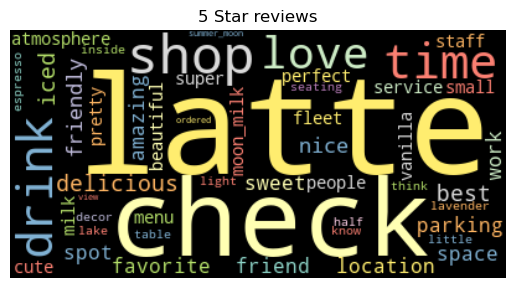

In [43]:
# Create lists containing the individual words from 3 star review ratings, icluding Bi/Tri-grams
wc5 = []
for i in data_processed5:
    for j in i:
        wc5.append(j)
    
# Count individual word occurances
counts = Counter(wc5)

# create the WordCloud object
wordcloud = WordCloud(min_word_length =3,
                      background_color='black',
                     colormap='Set3')

# generate the word cloud
wordcloud.generate_from_frequencies(dict(counts.most_common(50)))

#plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('5 Star reviews')
plt.show()

### 4.4.  Run LDA model and find best number of clusters, visualizing Coherence scores

Coherence score with 2 clusters: 0.3534367813231527
Perplexity:  -7.3
Coherence score with 3 clusters: 0.36153629876114174
Perplexity:  -7.36
Coherence score with 4 clusters: 0.3639608874640101
Perplexity:  -7.4
Coherence score with 5 clusters: 0.45898324527576834
Perplexity:  -7.45
Coherence score with 6 clusters: 0.4913944770326108
Perplexity:  -7.5


Text(0.5, 1.0, 'explained variance by n-components')

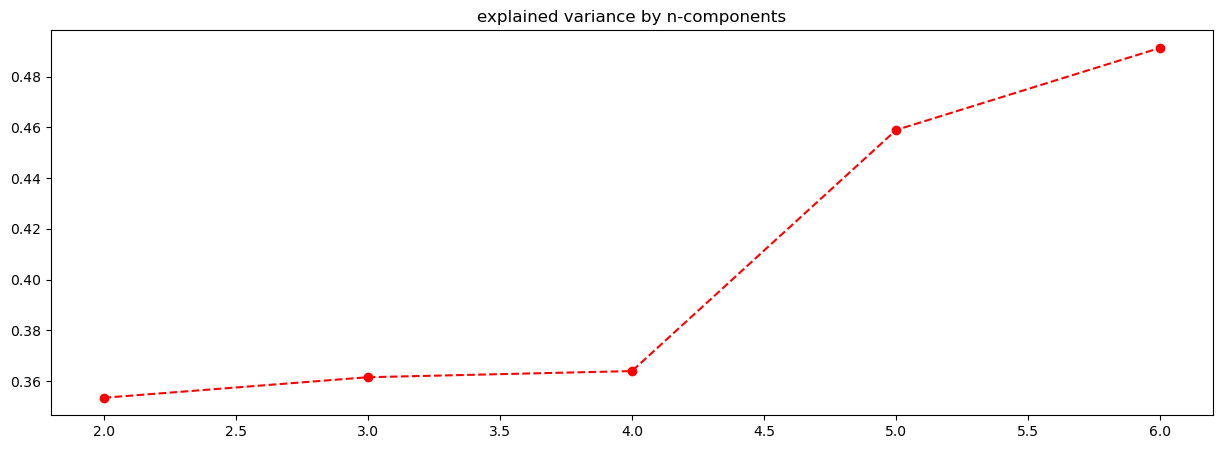

In [44]:
performance_lda_5 = []


# find the coherence score with a different number of topics
for i in range(2,7):
    lda = LdaModel(corpus=corpus5, id2word=id2word5, num_topics=i, random_state=42, alpha=1, eta=1 , passes=10, chunksize=10)
    # Compute coherence scores
    coherence_model = CoherenceModel(model=lda, texts=data_processed5, dictionary=id2word5, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    performance_lda_5.append(coherence_score)
    # Compute Perplexity (lower is better)
    print('Perplexity: ', round(lda.log_perplexity(corpus5), 2))

    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2,7), performance_lda_5, 'ro--')
plt.title('explained variance by n-components')

### 4.5.  Create the best LDA model using cluster with highest coherence score and find the Topic-Word distribution for each topic

In [45]:
# Create LDA model with 6 topics.
lda_5 = LdaModel(corpus=corpus5,id2word=id2word5,num_topics=6, random_state=42,alpha=1, eta=1 , passes=10,chunksize=10)

# find the 6 words with the srongest association to the derived topics
for topic_num, words in lda_5.print_topics(num_words=6):
    print('Words in topic {}: {}.'.format(topic_num, words))

Words in topic 0: 0.001*"south" + 0.001*"vegan" + 0.001*"winter_moon" + 0.001*"mozart" + 0.001*"creamy" + 0.001*"crowd".
Words in topic 1: 0.001*"south" + 0.001*"vegan" + 0.001*"party" + 0.001*"winter_moon" + 0.001*"sophie" + 0.001*"creamy".
Words in topic 2: 0.001*"south" + 0.001*"vegan" + 0.001*"winter_moon" + 0.001*"mozart" + 0.001*"creamy" + 0.001*"crowd".
Words in topic 3: 0.001*"south" + 0.001*"vegan" + 0.001*"winter_moon" + 0.001*"crowd" + 0.001*"creamy" + 0.001*"trip".
Words in topic 4: 0.016*"check" + 0.016*"latte" + 0.013*"time" + 0.012*"love" + 0.011*"shop" + 0.011*"drink".
Words in topic 5: 0.021*"moon_milk" + 0.021*"summer_moon" + 0.018*"half" + 0.014*"moon" + 0.009*"winter_moon" + 0.006*"order".


### 4.6.  Document-Topic count visualization
Since we have already assigned each document\review to the topic with the highest value, let's take a look at how many reviews fall into each category\topic.

Text(0.5, 1.0, 'Documents per Topic')

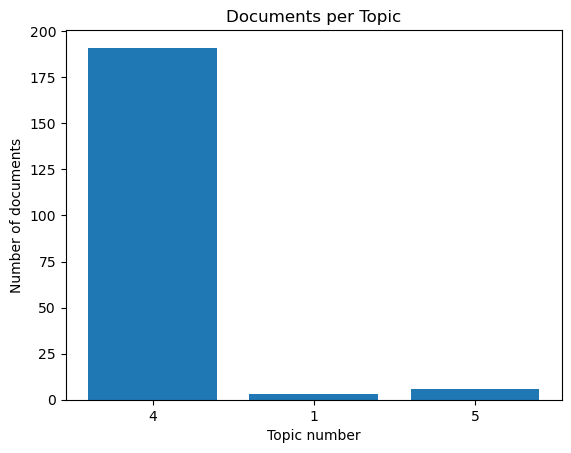

In [46]:
# Create a list that stores the main topic of each document.
topics_rating5 = []

# Go through each document from the 1 star corpus, and assign the main topic to the document
for i in range (len(corpus5)):
    # Get each document from the corpus and extract the topic distributions
    number = lda_5.get_document_topics(corpus5[i])
    topic = max(dict(number), key=dict(number).get)
    
    # We can print out the document topic as well as the document-topic distribution
    # print(f'From 3 star corpus, document {i} belongs mainly to Topic {topic}.')
    # print(f'Document {i} has the following "Topic-Value" distributions: {dict(number)}\n')
    
    # Add topic number of each document, used for plotting.
    topics_rating5.append(topic)
    
# Create dictionary containing the topic numbers and the number of documents for each topic
document_topic_count_5 = dict(Counter(topics_rating5))

# PLot the number of documents for each topic
plt.bar(range(len(document_topic_count_5)), list(document_topic_count_5.values()), align='center')
plt.xticks(range(len(document_topic_count_5)), list(document_topic_count_5.keys()))
plt.ylabel('Number of documents')
plt.xlabel('Topic number')
plt.title('Documents per Topic')

### 4.7.  5 Star Results interpretation

Once again, when looking at the graph, it is clear that topic 4 is the outright winner. Topic 4's keywords are: "check, latte, time, love, shop, drink". From these keywords it looks like customers really "Loved" the "Shop", possibly the interior and/or vibe, as well as their drinks, more specifically their "Latte's". As these restuarants are coffee shops, being reviewed 5 stars for your coffee provides a positive outlook from a business point of view.